In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir("../CPSL_TI_Radar")
from CPSL_TI_Radar.ConfigManager import ConfigManager

#specify the configuration path
config_folder_path = "/home/david/Documents/CPSL_TI_Radar/configurations"
#config_file = "DCA1000/custom_configs/ISAR_mocap.cfg"
config_file = "DCA1000/IWR1843_configs/IWR1843_demo.cfg"
path = os.path.join(config_folder_path,config_file)

#initialize the config manager
config_manager = ConfigManager()
config_manager.load_config_from_cfg(path)
config_manager.compute_radar_perforance()

In [52]:
#number of rx channels
rx_channels = config_manager.radar_performance["angle"]["num_rx_antennas"]

#samples per chirp
samples_per_chirp = int(config_manager.radar_config["profileCfg"]["adcSamples"])

#chirps per frame
chirp_start_profile_idx = int(config_manager.radar_config["frameCfg"]["startIndex"])
chirp_end_profile_idx = int(config_manager.radar_config["frameCfg"]["endIndex"])
chirps_per_loop = chirp_end_profile_idx - chirp_start_profile_idx + 1
chirp_loops_per_frame = int(config_manager.radar_config["frameCfg"]["loops"])
chirps_per_frame = chirp_loops_per_frame * chirps_per_loop

print("rx_channels:{}\nsamples_per_chirp:{}\nchirps per frame:{}\n".format(
    rx_channels,
    samples_per_chirp,
    chirps_per_frame
))

# compute range bins
range_res = config_manager.radar_performance["range"]["range_res"]
range_bins = np.arange(0, samples_per_chirp) * range_res

# compute doppler bins
vel_res = config_manager.radar_performance["velocity"]["vel_res"]
vel_max = config_manager.radar_performance["velocity"]["vel_max"]
num_vel_bins = int(config_manager.radar_performance["velocity"]["num_doppler_bins"])
velocity_bins = np.arange(-1 * vel_max, vel_max, vel_res)

rx_channels:4
samples_per_chirp:256
chirps per frame:32



In [53]:
#load an adc_data file
adc_file_path = "/home/david/Documents/CPSL_TI_Radar/CPSL_TI_Radar_cpp/build/adc_data.bin"
data = np.fromfile(adc_file_path,dtype=np.int16)
#convert the data into real and complex
data = data.reshape(2,-1)

#obtain the complex numbers
data = data[0] + 1j * data[1]

#indexed by [frame,rx channel, sample, chirp]
adc_data_cube = data.reshape(-1,rx_channels,samples_per_chirp,chirps_per_frame)
print(adc_data_cube.shape)

(27, 4, 256, 32)


Generate plots from the data:
NOTE: Some plots (range fft and range-doppler) don't make perfect sense at the moment and may need to be fixed.

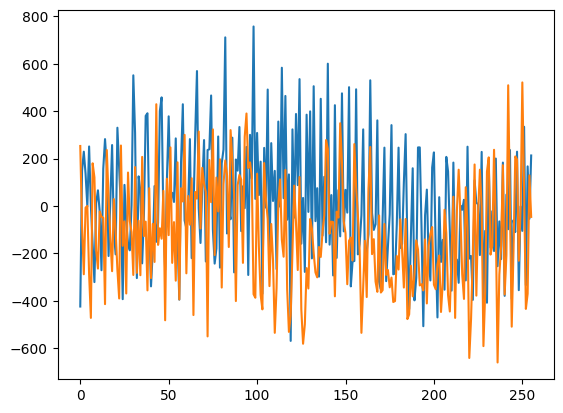

In [54]:
#plot the adc samples

frame = 10
chirp = 7
rx_antenna = 1

samples = adc_data_cube[frame,rx_antenna,:,chirp]

plt.plot(np.real(samples))
plt.plot(np.imag(samples))

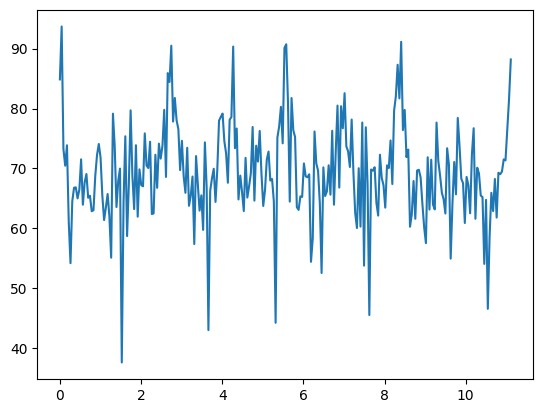

In [55]:
# plot the range FFT
samples = adc_data_cube[frame,rx_antenna,:,chirp]

# data = 20* np.abs(
#     np.log10(
#         np.fft.fftshift(
#             np.fft.fft(samples, axis=0)
#         )
#     )
# )

data = 20 * np.abs(
    np.log10(np.fft.fftshift(
        np.fft.fft(samples))
    )
)

plt.plot(range_bins,data)

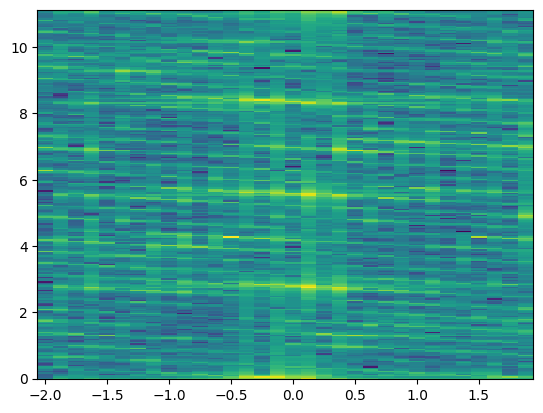

In [57]:
# plot the range Doppler plot
samples = adc_data_cube[frame,rx_antenna,:,:]

# # compute range FFT
# data = np.fft.fft(samples, axis=0)

# # compute doppler FFT
# data = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(data, axis=1),
#                                             axes=(0))))
data = 20 * np.abs(
    np.log10(
        np.fft.fftshift(
            x=np.fft.fft2(
                samples
            ),
            axes=None
        )
    )
)

#compute the range and doppler bins
vels,rngs = np.meshgrid(velocity_bins,range_bins)

plt.pcolormesh(vels,rngs,data)